In [60]:
from PIL import Image, ImageDraw, ImageFont
import random
import glob
import colorsys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import cv2
import skimage

In [3]:
image_size = 1000

In [10]:
def rand_error(r = 0.02):
    return int(random.uniform(-r, r)*image_size)

In [8]:
def get_random_bright_color():
    h,s,l = random.random(), 0.5 + random.random()/2.0, 0.4 + random.random()/5.0
    R,G,B = [int(256*i) for i in colorsys.hls_to_rgb(h,l,s)]
    return R,G,B

def get_dirty_white():
    return random.randint(230,255), random.randint(230,255), random.randint(230,255)

In [45]:
def get_random_target():
    R,G,B = get_random_bright_color()
    R_w, G_w, B_w = get_dirty_white()

    img = Image.new('RGB', (image_size, image_size), color = (R_w, G_w, B_w))
    coloured_box = Image.new('RGB', (image_size//2 + rand_error(), image_size//2 + rand_error()), color = (R, G, B))

    img.paste(coloured_box,(image_size//4 + rand_error(0.03), image_size//4 + rand_error(0.03)))

    letter = random.choice("ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789")
    font = random.choice(glob.glob("fonts\*"))
    fnt = ImageFont.truetype(font, int(image_size*0.75/2) + rand_error())

    d = ImageDraw.Draw(img)
    w,h = fnt.getsize(letter)
    d.text(((image_size-w)//2 + rand_error(),(image_size-h)//2 + rand_error()), letter, font=fnt, fill=(R_w, G_w, B_w))

    return img


In [33]:
grass_directory = "../data/grass_pretrain"

In [35]:
list_of_grass_images = glob.glob(grass_directory + "/*jpeg")

In [54]:
file_grass_img = random.choice(list_of_grass_images)

In [105]:
def paste_square(target_coords, grass_img, square_img):
    def find_coeffs(source_coords, target_coords):
        matrix = []
        for s, t in zip(source_coords, target_coords):
            matrix.append([t[0], t[1], 1, 0, 0, 0, -s[0]*t[0], -s[0]*t[1]])
            matrix.append([0, 0, 0, t[0], t[1], 1, -s[1]*t[0], -s[1]*t[1]])
        A = np.matrix(matrix, dtype=np.float)
        B = np.array(source_coords).reshape(8)
        res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
        return np.array(res).reshape(8)

    coeffs = find_coeffs(
        [(0, 0), (1000, 0), (1000, 1000), (0, 1000)],
        target_coords)

    warped_square_img = square_img.transform(grass_img.size, Image.PERSPECTIVE, coeffs,
                  Image.BICUBIC)

    mask = Image.new('L', square_img.size, color = 255).transform(grass_img.size, Image.PERSPECTIVE, coeffs,
                  Image.BICUBIC)


    grass_img.paste(warped_square_img, (0,0), mask)
    return grass_img


In [184]:
grass_img = Image.open(file_grass_img)
square_img = get_random_target()

In [136]:
grass_img = paste_square([(230, 430), (300, 420), (100, 100), (140, 250)], grass_img, square_img)

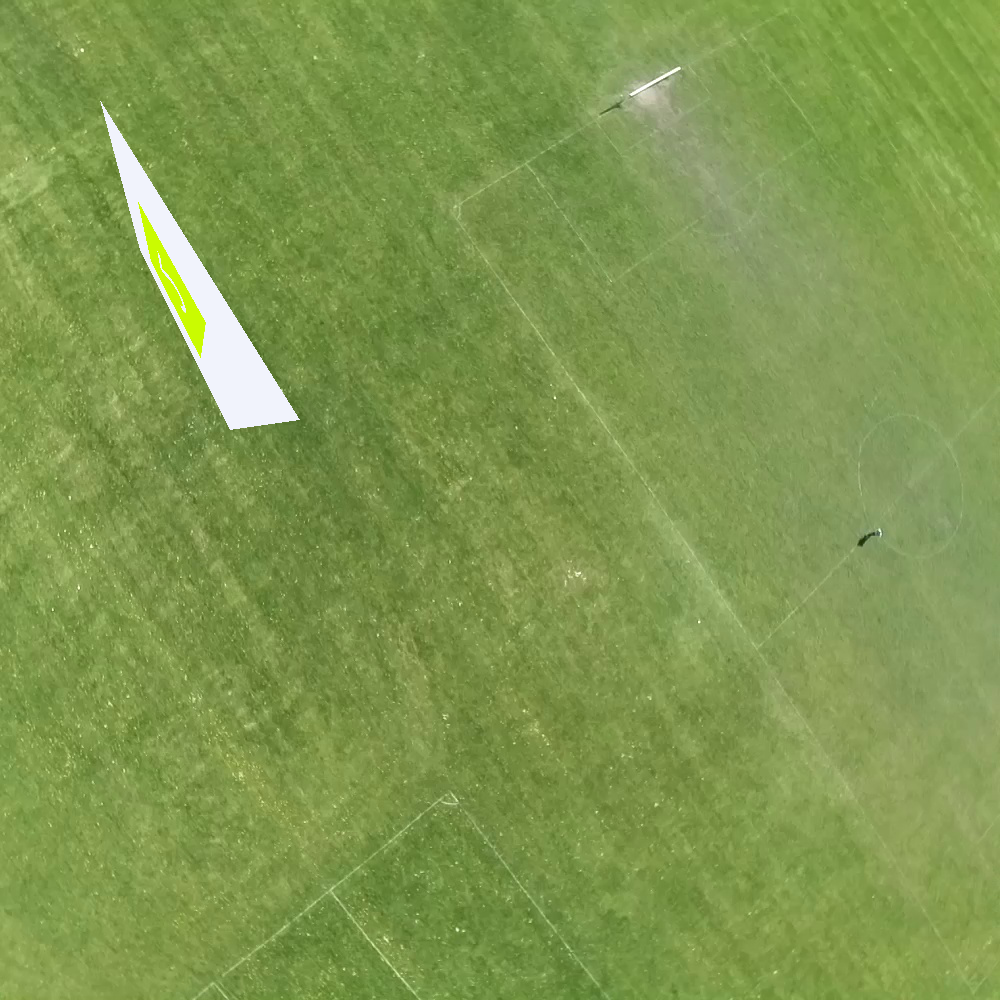

In [137]:
grass_img

In [143]:
A = (random.randint(-100, 1100), random.randint(-100, 1100))
B = (A[0] + random.randint(-300, 300), A[1] + random.randint(-300, 300)) 

0.7220338983050848

In [163]:
grad = (B[1] - A[1])/(B[0] - A[0])
c = midpoint[1] - grad * midpoint[0]
midpoint = ((B[0] + A[0])/2, (B[1] + A[1])/2)

In [166]:
new_X = random.randint(int(midpoint[0]), B[0])
new_Y = grad*new_X + c

In [180]:
import math

In [188]:
p_grad = -1/grad
p_c = midpoint[1] - p_grad * midpoint[0]
r = random.randint(0,300)
new_new_X = new_X + math.cos(math.atan(p_grad))*r
new_new_Y = new_Y + math.sin(math.atan(p_grad))*r

In [189]:
new_X, new_Y

(353, 862.5694915254237)

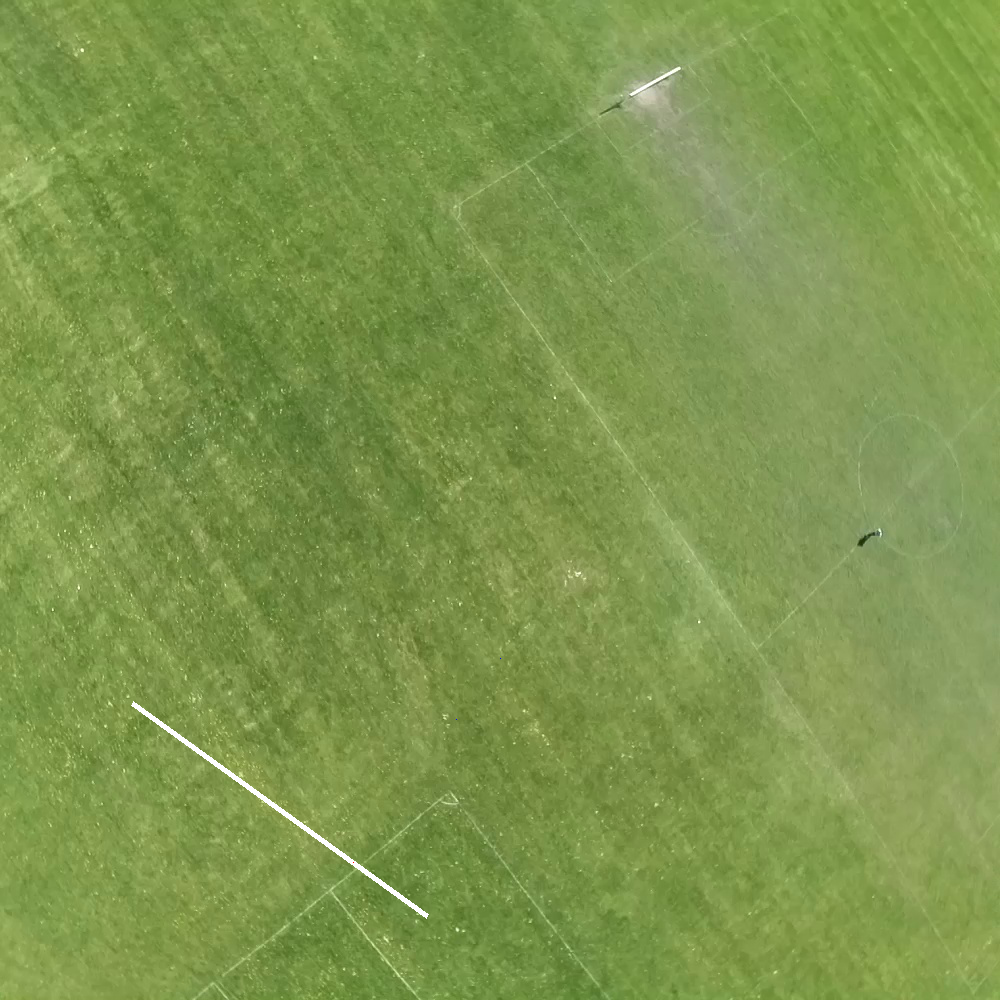

In [190]:
d = ImageDraw.Draw(grass_img)
d.line((A,B), width=5)
d.point((new_X,new_Y), fill = "red")
d.point((new_new_X,new_new_Y), fill = "blue")
grass_img